In [ ]:
!pip install boto3
!pip install git+https://github.com/sjsu2024-data298-team6/ultralytics.git
!pip install psycopg2-binary
from botocore.exceptions import ClientError
from google.colab import userdata
from pathlib import Path
from ultralytics import YOLO, RTDETR
from urllib.parse import urlparse
import boto3
import botocore
import glob
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import psycopg2
import re
import seaborn as sns
import wandb
import yaml
!rm -rf export
os.makedirs("export")

  Cloning https://github.com/sjsu2024-data298-team6/ultralytics.git to /tmp/pip-req-build-jwezzqgg
  Running command git clone --filter=blob:none --quiet https://github.com/sjsu2024-data298-team6/ultralytics.git /tmp/pip-req-build-jwezzqgg
  Resolved https://github.com/sjsu2024-data298-team6/ultralytics.git to commit 9d0c4cadcce475aa5e143373a357a8da00729367
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import psycopg2
from urllib.parse import urlparse

DATABASE_URL = userdata.get("D298_DB_URI")

def execute_query(query, data=None, fetch=False):
    try:
        result = urlparse(DATABASE_URL)
        db_user = result.username
        db_password = result.password
        db_name = result.path[1:]
        db_host = result.hostname
        db_port = result.port

        with psycopg2.connect(
            database=db_name,
            user=db_user,
            password=db_password,
            host=db_host,
            port=db_port
        ) as connection:
            with connection.cursor() as cursor:
                cursor.execute(query, data)
                if fetch:
                    results = cursor.fetchall()
                    return results
                else:
                    connection.commit()
                    return None

    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
query = 'SELECT * FROM "ModelResults" where "isActive"=True;'
results = execute_query(query, fetch=True)
for row in results:
    print(row[0], row[9])

20 ['yolov8', 'resnet-bifpn-single', 'shrey', 'custom_yolo', 'prod']
16 ['yolov11', 'baseline', 'yolo', 'prod']
17 ['yolov8', 'dce', 'justin', 'custom_yolo', 'prod']
24 ['yolov8', 'rtdetr-head', 'mhsa', 'austin', 'custom_rtdetr', 'prod']
26 ['rtdetr', 'baseline', 'rtdetr', 'prod']
27 ['yolov8', 'baseline', 'custom_yolo', 'prod']
18 ['yolov8', 'resnet-bifpn', 'shrey', 'custom_yolo', 'prod']


In [ ]:
df = pd.DataFrame(columns=["id", "datasetId", "modelTypeId", "params", "extras", "iouScore", "map50Score", "map5095Score", "inferenceTime", "tags", "resultsS3Key", "modelS3Key", "isActive", "tfjsS3Key"])
for r in results:
    df.loc[len(df)] = r
names = {
    17: "YOLOv8 w/ DCE",
    18: "YOLOv8 w/ ResNet & BiFPN (double)",
    19: "YOLOv8 w/ ViT & Involution",
    20: "YOLOv8 w/ ResNet & BiFPN (single)",
    16: "YOLOv11 Base",
    24: "YOLOv8 w/ RT-DETR MHSA",
    27: "YOLOv8 Base",
    26: "RT-DETR Base",
}
names = pd.DataFrame.from_dict(names, orient='index', columns=['Model'])
names["id"] = names.index
df = df.merge(names, on="id", how="left")
if df["Model"].isna().sum() > 0:
    print("fix names for the following entries")
    display(df[df["Model"].isna()])
    raise Exception("Stop here")

In [ ]:
df[["id", "Model", "tags"]]

,id,Model,tags
0,20,YOLOv8 w/ ResNet & BiFPN (single),"[yolov8, resnet-bifpn-single, shrey, custom_yo..."
1,16,YOLOv11 Base,"[yolov11, baseline, yolo, prod]"
2,17,YOLOv8 w/ DCE,"[yolov8, dce, justin, custom_yolo, prod]"
3,24,YOLOv8 w/ RT-DETR MHSA,"[yolov8, rtdetr-head, mhsa, austin, custom_rtd..."
4,26,RT-DETR Base,"[rtdetr, baseline, rtdetr, prod]"
5,27,YOLOv8 Base,"[yolov8, baseline, custom_yolo, prod]"
6,18,YOLOv8 w/ ResNet & BiFPN (double),"[yolov8, resnet-bifpn, shrey, custom_yolo, prod]"


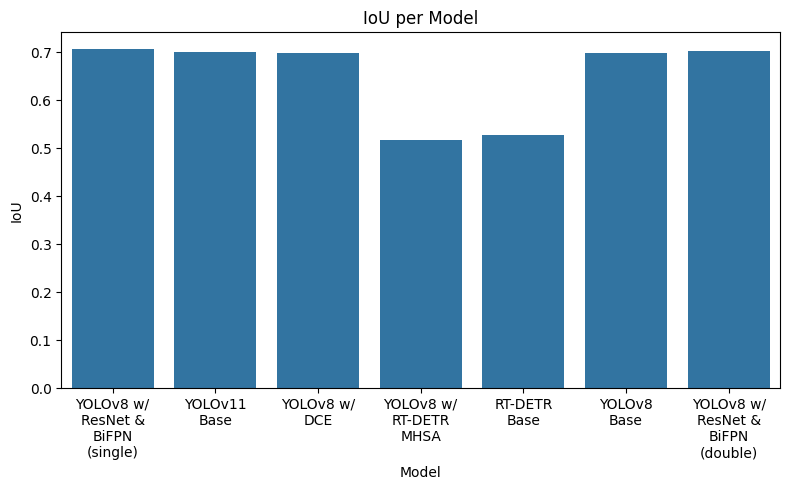

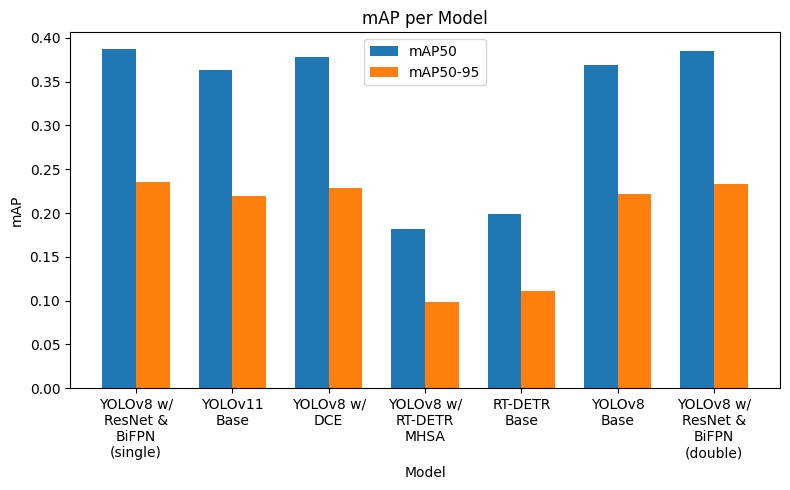

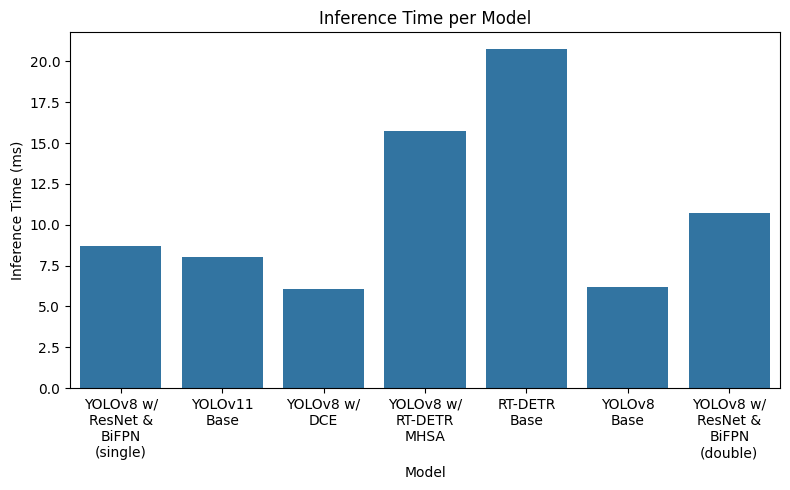

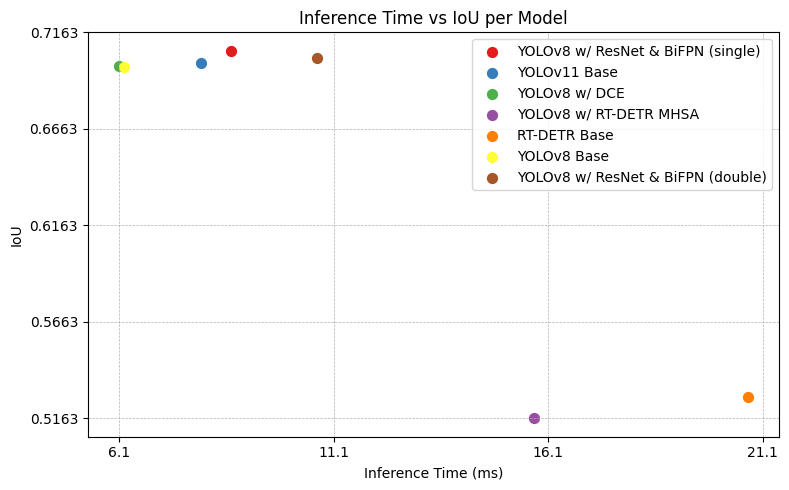

In [ ]:
figsize = (8, 5)

def split_model_name(name, max_length=10):
    words = name.split(' ')
    lines = []
    current_line = []
    current_length = 0

    for word in words:
        if current_length + len(word) + len(current_line) > max_length:
            lines.append(' '.join(current_line))
            current_line = [word]
            current_length = len(word)
        else:
            current_line.append(word)
            current_length += len(word)

    if current_line:
        lines.append(' '.join(current_line))

    return '\n'.join(lines)

plt.figure(figsize=figsize)
sns.barplot(x=df['Model'], y=df['iouScore'])
plt.title('IoU per Model')
plt.xlabel('Model')
plt.ylabel('IoU')
plt.xticks(
    ticks=range(len(df)),
    rotation=0,
    ha='center',
    labels=[split_model_name(model) for model in df['Model']],
)
plt.tight_layout()
plt.savefig('export/iou_per_model.png')
plt.show()

x = np.arange(len(df['Model']))
width = 0.35

fig, ax = plt.subplots(figsize=figsize)
rects1 = ax.bar(x - width / 2, df['map50Score'], width, label='mAP50')
rects2 = ax.bar(x + width / 2, df['map5095Score'], width, label='mAP50-95')

ax.set_title('mAP per Model')
ax.set_xlabel('Model')
ax.set_ylabel('mAP')
ax.set_xticks(x)
ax.set_xticklabels(
    [split_model_name(model) for model in df['Model']],
    rotation=0,
    ha='center',
)
ax.legend()

fig.tight_layout()
plt.savefig('export/map_per_model.png')
plt.show()

plt.figure(figsize=figsize)
sns.barplot(x=df['Model'], y=df['inferenceTime'])
plt.title('Inference Time per Model')
plt.xlabel('Model')
plt.ylabel('Inference Time (ms)')
plt.xticks(
    ticks=range(len(df)),
    rotation=0,
    ha='center',
    labels=[split_model_name(model) for model in df['Model']],
)
plt.tight_layout()
plt.savefig('export/inference_time_per_model.png')
plt.show()

plt.figure(figsize=figsize)
colors = sns.color_palette('Set1', len(df))

for i, model in enumerate(df['Model']):
    plt.scatter(
        df['inferenceTime'][i], df['iouScore'][i], color=colors[i], s=50, label=model
    )

plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

plt.xticks(
    np.arange(min(df['inferenceTime']), max(df['inferenceTime']) + 1, step=5)
)
plt.yticks(np.arange(min(df['iouScore']), max(df['iouScore']) + 0.05, step=0.05))

plt.title('Inference Time vs IoU per Model')
plt.xlabel('Inference Time (ms)')
plt.ylabel('IoU')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.savefig('export/inference_time_vs_iou.png')
plt.show()


In [ ]:
res = df[["Model", "iouScore", "map50Score", "map5095Score", "inferenceTime"]]
res

,Model,iouScore,map50Score,map5095Score,inferenceTime
0,YOLOv8 w/ ResNet & BiFPN (single),0.706346,0.387,0.2350,8.699875
1,YOLOv11 Base,0.700269,0.363,0.2190,8.001925
2,YOLOv8 w/ DCE,0.698758,0.378,0.2290,6.096575
3,YOLOv8 w/ RT-DETR MHSA,0.516254,0.182,0.0979,15.760954
4,RT-DETR Base,0.527081,0.199,0.1110,20.742532
5,YOLOv8 Base,0.698147,0.369,0.2220,6.202659
6,YOLOv8 w/ ResNet & BiFPN (double),0.702859,0.385,0.2330,10.701431


In [ ]:
res.to_csv("export/results.csv")

In [ ]:
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get("AWS_ACCESS_KEY_ID")
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get("AWS_SECRET_ACCESS_KEY")
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'

s3 = boto3.resource('s3')
BUCKET = "sjsu-fall24-data298-team6-bucket"

In [ ]:
!rm -rf data dataset.zip
s3.Bucket(BUCKET).download_file("dataset/yolo.zip", "dataset.zip")
!unzip -q -o dataset.zip -d data

In [ ]:
with open("data/data.yaml", "r") as fd:
    yaml_content = yaml.safe_load(fd.read())
names = yaml_content["names"]

In [ ]:
def draw_labeled_image(img, gt_text, pred_text, title=None, folder_=None):
    img_h, img_w, _ = img.shape
    ss = 4
    fig, ax = plt.subplots(1, 3, figsize=(3*ss, ss))
    ax[0].imshow(img)
    ax[0].axis("off")
    ax[1].imshow(img)
    ax[1].axis("off")
    ax[2].imshow(img)
    ax[2].axis("off")
    ax[0].set_title("Original")
    ax[1].set_title("Ground Truth")
    ax[2].set_title("Predicted (confidence)")

    for i, text in enumerate([gt_text, pred_text]):
        for line in text:
            try:
                class_id, x_center, y_center, width, height, conf = map(float, line.strip().split())
            except:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                conf = None


            class_id = int(class_id)

            x = (x_center - width / 2) * img_w
            y = (y_center - height / 2) * img_h
            w = width * img_w
            h = height * img_h

            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='lime', facecolor='none')
            ax[i+1].add_patch(rect)
            if conf is None:
                text = ax[i+1].text(x, y, names[class_id], color='white', fontsize=8, weight='bold')
            else:
                text = ax[i+1].text(x, y, f"{names[class_id]} ({conf})", color='white', fontsize=8, weight='bold')
            text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])

    plt.tight_layout()
    if folder_ is not None and title is not None:
        folder = "export/" + folder_
        os.makedirs(folder, exist_ok=True)
        plt.savefig(folder+"/"+title\
                    .replace(" ", "_")\
                    .replace("w/", "with")\
                    .replace("&", "and")\
                    .lower()+".png")
    plt.show()

In [ ]:
path = "data/test/images/"
imgs = os.listdir(path)

In [ ]:
# sq_diff = 0.3
# num_cls = 20
# num_uniq_cls = 2
# top_padding = 0.05
# right_padding = 0.3
# left_padding = 0.05
# bottom_padding = 0

# for i in range(len(imgs)):
#     test_img = path + imgs[i]
#     img = plt.imread(test_img)

#     img_h, img_w, _ = img.shape
#     ratio = img_h / img_w
#     if 1 - sq_diff > ratio or ratio > 1 + sq_diff:
#         continue

#     test_lbl = test_img.replace(".jpg", ".txt").replace("/images/", "/labels/")
#     with open(test_lbl, "r") as fd:
#         gt_text = fd.readlines()

#     cls = [x.split()[0] for x in gt_text]
#     if len(cls) > num_cls:
#         continue

#     if len(set(cls)) < num_uniq_cls:
#         continue

#     max_x = img_w * (1 - right_padding)
#     max_y = img_h * (1 - bottom_padding)

#     min_x = img_w * left_padding
#     min_y = img_h * top_padding

#     x_coords = [float(x.split()[1]) * img_w for x in gt_text]
#     y_coords = [float(x.split()[2]) * img_h for x in gt_text]

#     if max(x_coords) > max_x or min(x_coords) < min_x:
#         continue
#     if max(y_coords) > max_y or min(y_coords) < min_y:
#         continue

#     fake_pred = []
#     for line in gt_text:
#         fake_pred.append(f"{line.strip()} 0.08\n")

#     print(i, test_img)
#     draw_labeled_image(img, gt_text, fake_pred)

111, 516, 764, 355, 192

In [ ]:
df["Model"].values

array(['YOLOv8 w/ ResNet & BiFPN (single)', 'YOLOv11 Base', 'YOLOv8 w/ DCE', 'YOLOv8 w/ RT-DETR MHSA', 'RT-DETR Base', 'YOLOv8 Base', 'YOLOv8 w/ ResNet & BiFPN (double)'], dtype=object)

In [ ]:
custom_order = ['YOLOv8 Base','YOLOv11 Base','RT-DETR Base', 'YOLOv8 w/ ResNet & BiFPN (single)', 'YOLOv8 w/ ResNet & BiFPN (double)', 'YOLOv8 w/ DCE', 'YOLOv8 w/ RT-DETR MHSA' ]
custom_order = {x:i for i,x in enumerate(custom_order)}
df['custom_order'] = df['Model'].map(custom_order)
df = df.sort_values(by='custom_order')
df = df.drop(columns=['custom_order'])
df

,id,datasetId,modelTypeId,params,extras,iouScore,map50Score,map5095Score,inferenceTime,tags,resultsS3Key,modelS3Key,isActive,tfjsS3Key,Model
5,27,1,3,"{'batch': 8, 'imgsz': 640, 'epochs': 100}",{'YAML_URL': 'https://ftr6svvrko.ufs.sh/f/q3Y0...,0.698147,0.369,0.2220,6.202659,"[yolov8, baseline, custom_yolo, prod]",runs/custom_yolo_1743896708.zip,runs/custom_yolo_1743896708_weights.pt,True,,YOLOv8 Base
1,16,1,1,"{'batch': 8, 'imgsz': 640, 'epochs': 100}",{'wandb_logs': 'https://wandb.ai/sjsu_msda_tea...,0.700269,0.363,0.2190,8.001925,"[yolov11, baseline, yolo, prod]",runs/yolo_1743719798.zip,runs/yolo_1743719798_weights.pt,True,,YOLOv11 Base
4,26,1,2,"{'batch': 4, 'imgsz': 640, 'epochs': 100}",{'wandb_logs': 'https://wandb.ai/sjsu_msda_tea...,0.527081,0.199,0.1110,20.742532,"[rtdetr, baseline, rtdetr, prod]",runs/rtdetr_1743885565.zip,runs/rtdetr_1743885565_weights.pt,True,,RT-DETR Base
0,20,1,3,"{'batch': 4, 'imgsz': 640, 'epochs': 100}",{'YAML_URL': 'https://ftr6svvrko.ufs.sh/f/q3Y0...,0.706346,0.387,0.2350,8.699875,"[yolov8, resnet-bifpn-single, shrey, custom_yo...",runs/custom_yolo_1743784218.zip,runs/custom_yolo_1743784218_weights.pt,True,,YOLOv8 w/ ResNet & BiFPN (single)
6,18,1,3,"{'batch': 4, 'imgsz': 640, 'epochs': 100}",{'YAML_URL': 'https://ftr6svvrko.ufs.sh/f/q3Y0...,0.702859,0.385,0.2330,10.701431,"[yolov8, resnet-bifpn, shrey, custom_yolo, prod]",runs/custom_yolo_1743755320.zip,runs/custom_yolo_1743755320_weights.pt,True,,YOLOv8 w/ ResNet & BiFPN (double)
2,17,1,3,"{'batch': 4, 'imgsz': 640, 'epochs': 100}",{'YAML_URL': 'https://ftr6svvrko.ufs.sh/f/q3Y0...,0.698758,0.378,0.2290,6.096575,"[yolov8, dce, justin, custom_yolo, prod]",runs/custom_yolo_1743736377.zip,runs/custom_yolo_1743736377_weights.pt,True,,YOLOv8 w/ DCE
3,24,1,4,"{'batch': 4, 'imgsz': 640, 'epochs': 100}",{'YAML_URL': 'https://ftr6svvrko.ufs.sh/f/q3Y0...,0.516254,0.182,0.0979,15.760954,"[yolov8, rtdetr-head, mhsa, austin, custom_rtd...",runs/custom_rtdetr_1743827923.zip,runs/custom_rtdetr_1743827923_weights.pt,True,,YOLOv8 w/ RT-DETR MHSA


In [ ]:
img_idxs = [111, 516, 764, 355, 192]
all_results = {}
for i, row in df.iterrows():
    print(i, row)
    s3.Bucket(BUCKET).download_file(row["modelS3Key"], "model.pt")

    if "rtdetr" in "".join(row["tags"]):
        model = RTDETR("./model.pt")
    else:
        model = YOLO("./model.pt")

    for img_idx in img_idxs:

        test_img = path + imgs[img_idx]
        print(test_img)
        img = plt.imread(test_img)
        test_lbl = test_img.replace(".jpg", ".txt").replace("/images/", "/labels/")
        with open(test_lbl, "r") as fd:
            gt_text = fd.readlines()
        results = model(img)[0].cpu()

        pred = []
        for b in results.boxes:
            xywhn = " ".join([f"{bxy:.6f}" for bxy in b.xywhn[0]])
            pred.append(f"{int(b.cls)} {xywhn} {float(b.conf):.2f}")

        if img_idx not in all_results.keys():
            all_results[img_idx] = [[gt_text, "Ground Truth"]]
            all_results[img_idx].append([pred, f'{row["Model"]}'])
        else:
            all_results[img_idx].append([pred, f'{row["Model"]}'])
        draw_labeled_image(img, gt_text, pred, f'{row["Model"]}', str(img_idx))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for img_idx in img_idxs:
    test_img = path + imgs[img_idx]
    img = plt.imread(test_img)
    img_h, img_w, _ = img.shape
    fig, ax = plt.subplots(3,3, figsize=(14,12))
    ax = ax.flatten()
    for a in ax:
        a.axis("off")
        a.imshow(img)
    ax[0].set_title("Unlabled")
    for i, entry in enumerate(all_results[img_idx]):
        text = entry[0]
        title = entry[1]
        ax[i+1].set_title(title)
        for line in text:
            try:
                class_id, x_center, y_center, width, height, conf = map(float, line.strip().split())
            except:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                conf = None

            class_id = int(class_id)

            x = (x_center - width / 2) * img_w
            y = (y_center - height / 2) * img_h
            w = width * img_w
            h = height * img_h

            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='lime', facecolor='none')
            ax[i+1].add_patch(rect)
            if conf is None:
                text = ax[i+1].text(x, y, names[class_id], color='white', fontsize=8, weight='bold')
            else:
                text = ax[i+1].text(x, y, f"{names[class_id]} ({conf})", color='white', fontsize=8, weight='bold')
            text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])
    plt.tight_layout()
    plt.savefig(f"export/{img_idx}/all.png")
    plt.show()
    plt.imsave(f"export/{img_idx}/base.png", img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
wandb.login(key=userdata.get("WANDB_API"))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

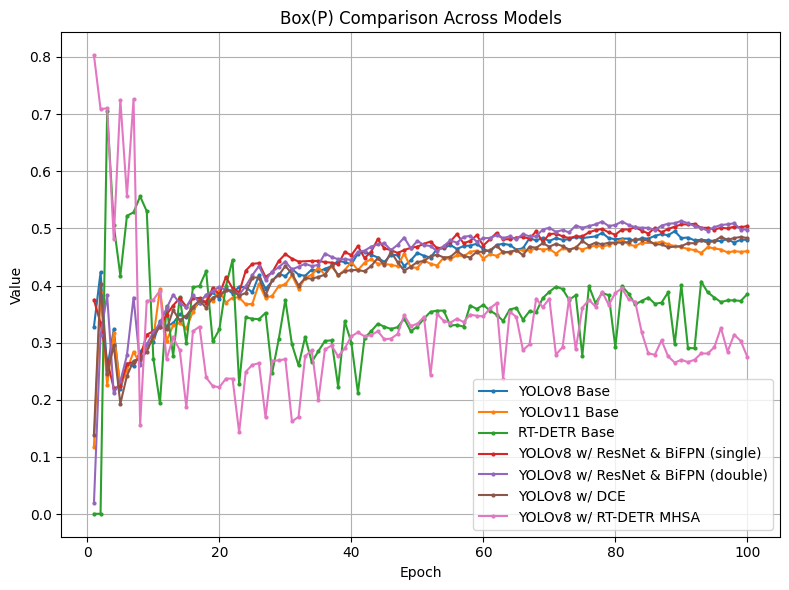

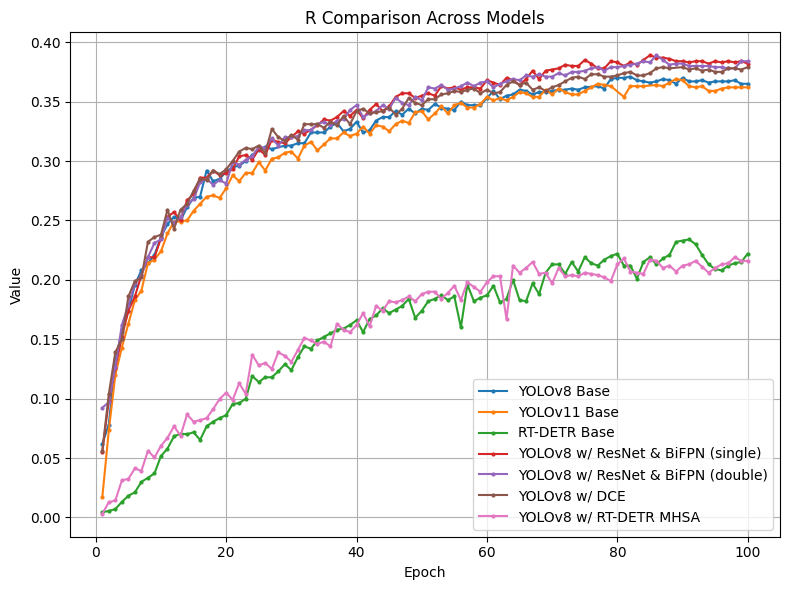

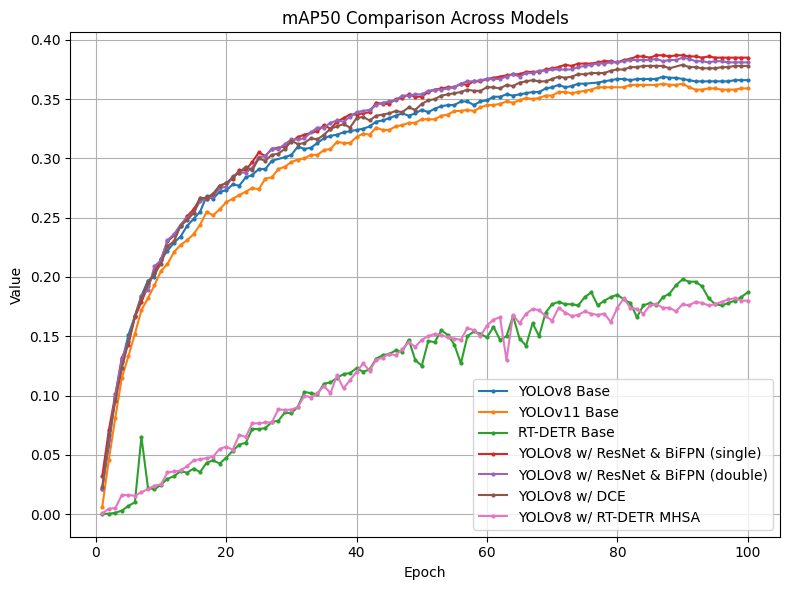

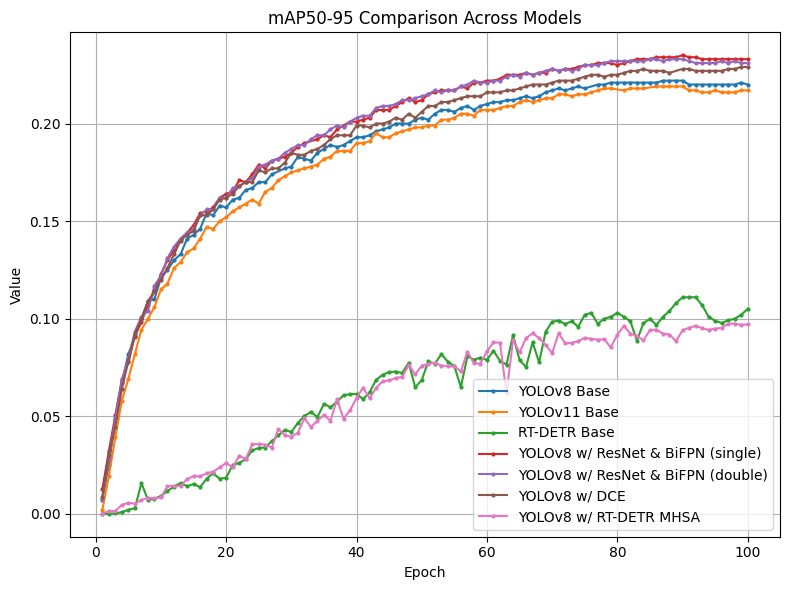

In [ ]:
os.makedirs("export/logs/", exist_ok=True)
metrics_dict = {}

for i, row in df.iterrows():
    wandb_url = row["extras"]["wandb_logs"]
    wandb_url = wandb_url.split("/")
    entity, project, run_id = wandb_url[3], wandb_url[4], wandb_url[6]
    api = wandb.Api()
    run = api.run(f"{entity}/{project}/{run_id}")
    model_name = row["Model"].replace(" ", "_")\
                .replace("w/", "with")\
                .replace("&", "and")\
                .lower()
    run.file("output.log").download(root=f"export/logs/{model_name}", replace=True)
    os.rename(f"export/logs/{model_name}/output.log", f"export/logs/{model_name}.log")
    os.rmdir(f"export/logs/{model_name}")
    log_file = f"export/logs/{model_name}.log"

    metrics = []
    with open(log_file, 'r') as f:
        lines = f.readlines()
        i = 0
        while i < len(lines) - 2:
            line = lines[i]

            epoch_match = re.search(r'^\s*(\d+)/\d+\s+\d+\.\d+G', line)

            if epoch_match:
                epoch = int(epoch_match.group(1))
                header_found = False
                metrics_found = False
                j = i + 1

                while j < min(i + 5, len(lines)) and not header_found:
                    if 'Box(P' in lines[j]:
                        header_found = True
                        k = j + 1
                        while k < min(j + 5, len(lines)) and not metrics_found:
                            if 'all' in lines[k]:
                                metrics_line = lines[k]
                                values = [x for x in metrics_line.strip().split() if x]
                                if len(values) >= 7:
                                    metrics.append({
                                        'epoch': epoch,
                                        'Box(P)': float(values[3]),
                                        'R': float(values[4]),
                                        'mAP50': float(values[5]),
                                        'mAP50-95': float(values[6])
                                    })
                                    metrics_found = True
                            k += 1
                    j += 1
            i += 1

    df = pd.DataFrame(metrics)
    metrics_dict[row["Model"]] = df


def plot_metric(metric, metrics_dict, output_dir):
    plt.figure(figsize=(8, 6))

    for model_name, df in metrics_dict.items():
        plt.plot(df['epoch'], df[metric], label=model_name, marker='o', markersize=2)

    plt.title(f'{metric} Comparison Across Models')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc="lower right")

    plt.tight_layout()

    output_file = output_dir / f'{metric.replace("/", "_")}_comparison.png'
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()

output_dir = Path("export/metric_plots")
output_dir.mkdir(exist_ok=True)
metrics = ['Box(P)', 'R', 'mAP50', 'mAP50-95']
for metric in metrics:
    plot_metric(metric, metrics_dict, output_dir)

In [ ]:
!zip -r export.zip export

updating: export/ (stored 0%)
updating: export/192/ (stored 0%)
updating: export/192/yolov8_with_resnet_and_bifpn_(single).png (deflated 2%)
updating: export/192/yolov8_base.png (deflated 2%)
updating: export/192/yolov8_with_dce.png (deflated 2%)
updating: export/192/base.png (deflated 0%)
updating: export/192/yolov8_with_resnet_and_bifpn_(double).png (deflated 2%)
updating: export/192/yolov11_base.png (deflated 2%)
updating: export/192/yolov8_with_rt-detr_mhsa.png (deflated 2%)
updating: export/192/all.png (deflated 1%)
updating: export/192/rt-detr_base.png (deflated 2%)
updating: export/metric_plots/ (stored 0%)
updating: export/metric_plots/Box(P)_comparison.png (deflated 4%)
updating: export/metric_plots/mAP50-95_comparison.png (deflated 5%)
updating: export/metric_plots/R_comparison.png (deflated 4%)
updating: export/metric_plots/mAP50_comparison.png (deflated 5%)
updating: export/results.csv (deflated 40%)
updating: export/inference_time_vs_iou.png (deflated 17%)
updating: export

In [ ]:
# yamls = ["yolo11s.yaml", "yolov8s.yaml"]
yamls = ["rtdetr-l.yaml","yolo11s.yaml", "yolov8s.yaml"]
custom_ns = os.listdir("/usr/local/lib/python3.11/dist-packages/ultralytics/cfg/models/custom")
custom = []
skip = ["yolov8-invo.yaml", "yolov8-resnet-efficientDetBiFPN.yaml"]
for c in custom_ns:
    if c in skip:
        continue
    custom.append(c.replace("8", "8s"))
yamls.extend(custom)
yamls

['rtdetr-l.yaml',
 'yolo11s.yaml',
 'yolov8s.yaml',
 'yolov8s-resnet-efficientDetBiFPNsingle.yaml',
 'yolov8s-dce.yaml',
 'yolov8s-resnet-efficientDetBiFPN-alt.yaml',
 'yolov8s-mhsa.yaml',
 'yolov8s-vit_invo.yaml']

In [ ]:
yaml_to_model_name = {
    "rtdetr-l.yaml": "RT-DETR Base",
    "yolo11s.yaml": "YOLOv11 Base",
    "yolov8s.yaml": "YOLOv8 Base",
    "yolov8s-dce.yaml": "YOLOv8 w/ DCE",
    "yolov8-invo.yaml": "YOLOv8 w/ Involution",
    "yolov8s-resnet-efficientDetBiFPNsingle.yaml": "YOLOv8 w/ ResNet & BiFPN (single)",
    "yolov8s-vit_invo.yaml": "YOLOv8 w/ ViT & Involution",
    "yolov8s-resnet-efficientDetBiFPN-alt.yaml": "YOLOv8 w/ ResNet & BiFPN (double)",
    "yolov8s-mhsa.yaml": "YOLOv8 w/ MHSA",
    "yolov8s-resnet-efficientDetBiFPN.yaml": "YOLOv8 w/ ResNet & BiFPN (double)?"
}

In [ ]:
df_ = pd.DataFrame(columns=["Model", "# Layers", "# Parameters", "# Gradients", "GFLOPs"])
for y in yamls:
    print(yaml_to_model_name[y])
    p = YOLO(y, task="detect").info()
    df_.loc[len(df_)] = ([yaml_to_model_name[y], *p])
df_.head(10)

RT-DETR Base
WARNING ⚠️ no model scale passed. Assuming scale='l'.
rtdetr-l summary: 457 layers, 32,970,476 parameters, 32,970,476 gradients, 108.3 GFLOPs
YOLOv11 Base
YOLO11s summary: 181 layers, 9,458,752 parameters, 9,458,736 gradients, 21.7 GFLOPs
YOLOv8 Base
YOLOv8s summary: 129 layers, 11,166,560 parameters, 11,166,544 gradients, 28.8 GFLOPs
YOLOv8 w/ ResNet & BiFPN (single)
YOLOv8s-resnet-efficientDetBiFPNsingle summary: 218 layers, 30,935,863 parameters, 30,935,847 gradients, 83.2 GFLOPs
YOLOv8 w/ DCE
YOLOv8s-dce summary: 125 layers, 2,846,496 parameters, 2,846,480 gradients, 30.8 GFLOPs


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


YOLOv8 w/ ResNet & BiFPN (double)
YOLOv8s-resnet-efficientDetBiFPN-alt summary: 260 layers, 32,726,336 parameters, 32,726,320 gradients, 88.7 GFLOPs
YOLOv8 w/ MHSA
YOLOv8s-mhsa summary: 240 layers, 22,326,197 parameters, 22,326,197 gradients, 35.9 GFLOPs
YOLOv8 w/ ViT & Involution
YOLOv8s-vit_invo summary: 141 layers, 12,511,392 parameters, 12,511,376 gradients, 41.9 GFLOPs


,Model,# Layers,# Parameters,# Gradients,GFLOPs
0,RT-DETR Base,457,32970476,32970476,108.343706
1,YOLOv11 Base,181,9458752,9458736,21.718374
2,YOLOv8 Base,129,11166560,11166544,28.816845
3,YOLOv8 w/ ResNet & BiFPN (single),218,30935863,30935847,83.228314
4,YOLOv8 w/ DCE,125,2846496,2846480,30.757539
5,YOLOv8 w/ ResNet & BiFPN (double),260,32726336,32726320,88.743987
6,YOLOv8 w/ MHSA,240,22326197,22326197,35.860275
7,YOLOv8 w/ ViT & Involution,141,12511392,12511376,41.862707


In [ ]:
def format_dataframe_numbers(df):
    def format_number(x):
        if isinstance(x, (int, float)):
            return "{:,}".format(int(x))
        if isinstance(x, str):
            return x.replace("&", "\\&")
        return x

    return df.map(format_number)

formatted_df = format_dataframe_numbers(df_.sort_values("# Parameters").copy())
print(formatted_df\
      .replace("&", "\\&")\
      .to_latex(index=False,bold_rows=True)\
      .replace("_", "\\_")\
      .replace("#", "\\#")\
      .replace("toprule", "hline").replace("midrule", "hline").replace("bottomrule", "hline")
      )

\begin{tabular}{lllll}
\hline
Model & \# Layers & \# Parameters & \# Gradients & GFLOPs \\
\hline
YOLOv8 w/ DCE & 125 & 2,846,496 & 2,846,480 & 30 \\
YOLOv11 Base & 181 & 9,458,752 & 9,458,736 & 21 \\
YOLOv8 Base & 129 & 11,166,560 & 11,166,544 & 28 \\
YOLOv8 w/ ViT \& Involution & 141 & 12,511,392 & 12,511,376 & 41 \\
YOLOv8 w/ MHSA & 240 & 22,326,197 & 22,326,197 & 35 \\
YOLOv8 w/ ResNet \& BiFPN (single) & 218 & 30,935,863 & 30,935,847 & 83 \\
YOLOv8 w/ ResNet \& BiFPN (double) & 260 & 32,726,336 & 32,726,320 & 88 \\
RT-DETR Base & 457 & 32,970,476 & 32,970,476 & 108 \\
\hline
\end{tabular}

